In [1]:
import joblib
import os

from torchtext.data import Field, BucketIterator
from torchtext.data import TabularDataset
import torch

import pandas as pd
from tqdm import tqdm_notebook as tqdm
import re
from torchtext.data import Iterator, BucketIterator

# Config

In [2]:
development = True
use_cuda = True
d_path = r'cnndm-pj/'

MIN_LEN_X = 10
MIN_LEN_Y = 10
MAX_LEN_X = 400
MAX_LEN_Y = 100
MIN_NUM_X = 1
MAX_NUM_X = 1
MAX_NUM_Y = None
W_LS = "<s>"
W_RS = "</s>"
SUMM_BEGIN_TOKEN = r"-lrb- .* -rrb-"
PRETRAINED_VECTOR = 'glove.6B.200d' 

In [3]:
device = (
        torch.device("cuda")
        if use_cuda and torch.cuda.is_available()
        else torch.device("cpu")
    )

# Using Fastai to load process data

In [4]:
from fastai import *
from fastai.text import *

In [5]:
def seq2seq_collate(samples, pad_idx=1, pad_first=True, backwards=False):
    "Function that collect samples and adds padding. Flips token order if needed"
    samples = to_data(samples)
    max_len_x,max_len_y = max([len(s[0]) for s in samples]),max([len(s[1]) for s in samples])
    res_x = torch.zeros(len(samples), max_len_x).long() + pad_idx
    res_y = torch.zeros(len(samples), max_len_y).long() + pad_idx
    if backwards: pad_first = not pad_first
    for i,s in enumerate(samples):
        if pad_first: 
            res_x[i,-len(s[0]):],res_y[i,-len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
        else:         
            res_x[i,:len(s[0]):],res_y[i,:len(s[1]):] = LongTensor(s[0]),LongTensor(s[1])
    if backwards: res_x,res_y = res_x.flip(1),res_y.flip(1)
    return res_x,res_y

In [6]:
class Seq2SeqDataBunch(TextDataBunch):
    "Create a `TextDataBunch` suitable for training an RNN classifier."
    @classmethod
    def create(cls, train_ds, valid_ds, test_ds=None, path:PathOrStr='.', bs:int=32, val_bs:int=None, pad_idx=1,
               dl_tfms=None, pad_first=False, device:torch.device=None, no_check:bool=False, backwards:bool=False, **dl_kwargs) -> DataBunch:
        "Function that transform the `datasets` in a `DataBunch` for classification. Passes `**dl_kwargs` on to `DataLoader()`"
        datasets = cls._init_ds(train_ds, valid_ds, test_ds)
        val_bs = ifnone(val_bs, bs)
        collate_fn = partial(seq2seq_collate, pad_idx=pad_idx, pad_first=pad_first, backwards=backwards)
        train_sampler = SortishSampler(datasets[0].x, key=lambda t: len(datasets[0][t][0].data), bs=bs//2)
        train_dl = DataLoader(datasets[0], batch_size=bs, sampler=train_sampler, drop_last=True, **dl_kwargs)
        dataloaders = [train_dl]
        for ds in datasets[1:]:
            lengths = [len(t) for t in ds.x.items]
            sampler = SortSampler(ds.x, key=lengths.__getitem__)
            dataloaders.append(DataLoader(ds, batch_size=val_bs, sampler=sampler, **dl_kwargs))
        return cls(*dataloaders, path=path, device=device, collate_fn=collate_fn, no_check=no_check)

In [7]:
class Seq2SeqTextList(TextList):
    _bunch = Seq2SeqDataBunch
    _label_cls = TextList

In [8]:
if development:
    train_df = pd.read_csv(os.path.join(d_path,'train_processed.txt'), sep="|", names=['article','summary'], nrows=20000)
else:
    train_df = pd.read_csv(os.path.join(d_path,'train_processed.txt'), sep="|", names=['article','summary'])

valid_df = pd.read_csv(os.path.join(d_path,'val_processed.txt'), sep="|", names=['article','summary'])
test_df = pd.read_csv(os.path.join(d_path,'test_processed.txt'), sep="|", names=['article','summary'])


In [9]:
train_df['is_valid'] = False
valid_df['is_valid'] = True
df = pd.concat([train_df, valid_df])

In [10]:
src = Seq2SeqTextList.from_df(df, path = d_path, cols='article').split_from_df().label_from_df(cols='summary', label_cls=TextList)

In [11]:
np.percentile([len(o) for o in src.train.x.items] + [len(o) for o in src.valid.x.items], 90)

381.0

In [12]:
np.percentile([len(o) for o in src.train.y.items] + [len(o) for o in src.valid.y.items], 90)

67.0

### Removing the outliers for better training

In [13]:
src = src.filter_by_func(lambda x,y: len(x) > 400 or len(y) > 75)

In [14]:
batch_size = 64
if development:
    num_workers = 0
else:
    num_workers = 8

In [15]:
num_workers

0

In [16]:
data = src.databunch(bs = batch_size, num_workers = num_workers, device = device)

In [17]:
data.save()

Finally, we are done with processing the dataset: pre-processing, numericalizing, batching and padding.

Lets take a look at the final processed data 

In [18]:
#number of batches in training & validation set and number of tokens in vocabulary
len(data.train_dl), len(data.valid_dl), len(data.vocab.itos)

(312, 73, 38608)

In [43]:
#shape of one batch in training set (sequence_length x batch_size)
xb,yb = next(iter(data.train_ds))
xb.data.size, yb.data.size

(253, 46)

In [19]:
#lets look at an example pair
data.show_batch()

text,target
xxbos the eight airlines around the world that have the boeing 787 dreamliner in their fleets are set to resume commercial flights of the aircraft by early june . qatar airways was the latest airline to confirm it would resume dreamliner flights between doha and dubai this week and a longer service from doha to london 's heathrow starting may 15 . ethiopian airlines was the first to xxunk passenger,xxbos eight airlines operate the dreamliner . ethiopian airlines resumed services on saturday . the xxunk of flights comes after the faa lifted the grounding of the 787 . boeing is working with the airlines to replace battery systems .
xxbos the eight airlines around the world that have the boeing 787 dreamliner in their fleets are set to resume commercial flights of the aircraft by early june . qatar airways was the latest airline to confirm it would resume dreamliner flights between doha and dubai this week and a longer service from doha to london 's heathrow starting may 15 . ethiopian airlines was the first to xxunk passenger,xxbos eight airlines operate the dreamliner . ethiopian airlines resumed services on saturday . the xxunk of flights comes after the faa lifted the grounding of the 787 . boeing is working with the airlines to replace battery systems .
xxbos the eight airlines around the world that have the boeing 787 dreamliner in their fleets are set to resume commercial flights of the aircraft by early june . qatar airways was the latest airline to confirm it would resume dreamliner flights between doha and dubai this week and a longer service from doha to london 's heathrow starting may 15 . ethiopian airlines was the first to xxunk passenger,xxbos eight airlines operate the dreamliner . ethiopian airlines resumed services on saturday . the xxunk of flights comes after the faa lifted the grounding of the 787 . boeing is working with the airlines to replace battery systems .
xxbos the eight airlines around the world that have the boeing 787 dreamliner in their fleets are set to resume commercial flights of the aircraft by early june . qatar airways was the latest airline to confirm it would resume dreamliner flights between doha and dubai this week and a longer service from doha to london 's heathrow starting may 15 . ethiopian airlines was the first to xxunk passenger,xxbos eight airlines operate the dreamliner . ethiopian airlines resumed services on saturday . the xxunk of flights comes after the faa lifted the grounding of the 787 . boeing is working with the airlines to replace battery systems .
xxbos the eight airlines around the world that have the boeing 787 dreamliner in their fleets are set to resume commercial flights of the aircraft by early june . qatar airways was the latest airline to confirm it would resume dreamliner flights between doha and dubai this week and a longer service from doha to london 's heathrow starting may 15 . ethiopian airlines was the first to xxunk passenger,xxbos eight airlines operate the dreamliner . ethiopian airlines resumed services on saturday . the xxunk of flights comes after the faa lifted the grounding of the 787 . boeing is working with the airlines to replace battery systems .


In [20]:
v = data.vocab
print("Length of the Vocabulary: {}".format(len(v.itos)))
print ("Top 20 most popular words in the vocabulary")
[v.itos[i] for i in range(0,20)]

Length of the Vocabulary: 38608
Top 20 most popular words in the vocabulary


['xxunk',
 'xxpad',
 'xxbos',
 'xxeos',
 'xxfld',
 'xxmaj',
 'xxup',
 'xxrep',
 'xxwrep',
 'the',
 '.',
 ',',
 'to',
 'of',
 'a',
 'and',
 '`',
 'in',
 "'s",
 "''"]

In [11]:
data = load_data(d_path)

## Pretrained Embeddings

In [15]:
import fasttext as ft


In [16]:
# ! wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz -P {path}


'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [21]:
from torchtext.vocab import GloVe

glove_embed = GloVe(name='6B', dim=200)

In [31]:
# #For fasttext
# def create_emb(vecs, itos, em_sz=200, mult=1.):
#     emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
#     wgts = emb.weight.data
#     vec_dic = {w:vecs.get_word_vector(w) for w in vecs.get_words()}
#     miss = []
#     for i,w in enumerate(itos):
#         try: wgts[i] = tensor(vec_dic[w])
#         except: miss.append(w)
#     return emb

In [22]:
#For torchtext Glove
def create_emb(vecs, itos, em_sz=200, mult=1.):
    emb = nn.Embedding(len(itos), em_sz, padding_idx=1)
    wgts = vecs.vectors
    vec_dic = {word: embedding for word, embedding in zip(vecs.itos, vecs.vectors)}
    miss = []
    for i,w in enumerate(itos):
        try: wgts[i] = tensor(vec_dic[w])
        except: miss.append(w)
    return emb

In [23]:
emb_enc = create_emb(glove_embed, data.x.vocab.itos)
emb_dec = create_emb(glove_embed, data.y.vocab.itos)

In [24]:
emb_enc.weight.size(), emb_dec.weight.size()

(torch.Size([38608, 200]), torch.Size([18192, 200]))

In [25]:
torch.save(emb_enc, os.path.join(d_path,'src_emb.pth'))
torch.save(emb_dec, os.path.join(d_path,'trg_emb.pth'))

C:\anaconda3\lib\site-packages\torch\serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Embedding. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [48]:
emb_enc = torch.load(os.path.join(d_path,'src_emb.pth'))
emb_dec = torch.load(os.path.join(d_path,'trg_emb.pth'))

## Model

In [26]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, emb_enc, emb_dec, 
                    nh, out_sl, 
                    nl=2, bos_idx=0, pad_idx=1):
        super().__init__()
        self.nl,self.nh,self.out_sl = nl,nh,out_sl
        self.bos_idx,self.pad_idx = bos_idx,pad_idx
        self.em_sz_enc = emb_enc.embedding_dim
        self.em_sz_dec = emb_dec.embedding_dim
        self.voc_sz_dec = emb_dec.num_embeddings
                 
        self.emb_enc = emb_enc
        self.emb_enc_drop = nn.Dropout(0.15)
        self.gru_enc = nn.GRU(self.em_sz_enc, nh, num_layers=nl,
                              dropout=0.25, batch_first=True)
        self.out_enc = nn.Linear(nh, self.em_sz_dec, bias=False)
        
        self.emb_dec = emb_dec
        self.gru_dec = nn.GRU(self.em_sz_dec, self.em_sz_dec, num_layers=nl,
                              dropout=0.1, batch_first=True)
        self.out_drop = nn.Dropout(0.35)
        self.out = nn.Linear(self.em_sz_dec, self.voc_sz_dec)
        self.out.weight.data = self.emb_dec.weight.data
        
    def encoder(self, bs, inp):
        h = self.initHidden(bs)
        emb = self.emb_enc_drop(self.emb_enc(inp))
        _, h = self.gru_enc(emb, h)
        h = self.out_enc(h)
        return h
    
    def decoder(self, dec_inp, h):
        emb = self.emb_dec(dec_inp).unsqueeze(1)
        outp, h = self.gru_dec(emb, h)
        outp = self.out(self.out_drop(outp[:,0]))
        return h, outp
        
    def forward(self, inp):
        bs, sl = inp.size()
        h = self.encoder(bs, inp)
        dec_inp = inp.new_zeros(bs).long() + self.bos_idx
        
        res = []
        for i in range(self.out_sl):
            h, outp = self.decoder(dec_inp, h)
            dec_inp = outp.max(1)[1]
            res.append(outp)
            if (dec_inp==self.pad_idx).all(): break
        return torch.stack(res, dim=1)
    
    def initHidden(self, bs): return one_param(self).new_zeros(self.nl, bs, self.nh)

In [27]:
rnn = Seq2SeqRNN(emb_enc, emb_dec, nh=256, out_sl=75)

In [28]:

def seq2seq_loss(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    return CrossEntropyFlat()(out, targ)

## Train

In [29]:
learn = Learner(data, rnn, loss_func=seq2seq_loss)

In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


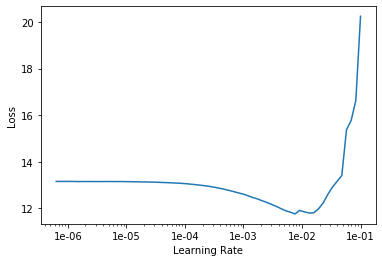

In [31]:
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,time
0,2.389531,15.959144,1:48:09


In [33]:
def seq2seq_acc(out, targ, pad_idx=1):
    bs,targ_len = targ.size()
    _,out_len,vs = out.size()
    if targ_len>out_len: out  = F.pad(out,  (0,0,0,targ_len-out_len,0,0), value=pad_idx)
    if out_len>targ_len: targ = F.pad(targ, (0,out_len-targ_len,0,0), value=pad_idx)
    out = out.argmax(2)
    return (out==targ).float().mean()

def get_predictions(learn, ds_type=DatasetType.Valid):
    learn.model.eval()
    inputs, targets, outputs = [],[],[]
    with torch.no_grad():
        for xb,yb in progress_bar(learn.dl(ds_type)):
            out = learn.model(xb)
            for x,y,z in zip(xb,yb,out):
                inputs.append(learn.data.train_ds.x.reconstruct(x))
                targets.append(learn.data.train_ds.y.reconstruct(y))
                outputs.append(learn.data.train_ds.y.reconstruct(z.argmax(1)))
    return inputs, targets, outputs

In [34]:
inputs, targets, outputs = get_predictions(learn)

In [39]:
idx= 800

In [40]:
print("#"*50+"Input"+"#"*50)
print(inputs[idx])
print("#"*50+"Target"+"#"*50)
print(targets[idx])
print("#"*50+"Predicted"+"#"*50)
print(outputs[idx])

##################################################Input##################################################
xxbos a teacher and wrestling coach has been charged after allegedly having sex with a high school wrestler . megan blair baker , 25 , has been accused of sexual contact with a 17-year - old xxunk xxunk high school student amid reports that she had sex with him on a school bus in january . the teacher , from xxunk , missouri who is believed to be married , was indicted by grand jury on march 20 . she was freed on $ 7,500 bond , xxunk reported . scroll down for video . teacher and wrestling coach megan blair baker , 25 , has been accused of sexual contact with a 17-year - old xxunk xxunk high school student . according to members of the school community who spoke to the local tv station , the teenage boy ` had been bragging ' about what happened with the teacher . the boy 's father reported the incident to police on february 2 . school superintendent tim gallagher told daily mail on